https://unit8co.github.io/darts/
https://www.analyticsvidhya.com/blog/2021/10/time-series-forecasting-made-easy-using-darts/
https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html
https://medium.com/mlearning-ai/easiest-way-to-implement-different-time-series-models-using-dart-40bdb794fd1a

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import *
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler

In [19]:
datas = pd.read_csv('월별공급량및비중all.csv')
data = pd.DataFrame()
data["IND"] = datas["도시가스(톤)_산업용"]
data

,IND
0,83809.0
1,70427.0
2,62652.0
3,47050.0
4,30709.0
...,...
295,457970.0
296,525619.0
297,600890.0
298,665901.0


In [20]:
kospi = pd.read_csv('코스피지수.csv')
data2 = kospi['종가']
# data['kospi'] = data2
data.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
data

,IND
1996-01-01,83809.0
1996-02-01,70427.0
1996-03-01,62652.0
1996-04-01,47050.0
1996-05-01,30709.0
...,...
2020-08-01,457970.0
2020-09-01,525619.0
2020-10-01,600890.0
2020-11-01,665901.0


In [21]:
series = TimeSeries.from_dataframe(data)
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_scaled

<TimeSeries (DataArray) (time: 300, component: 1, sample: 1)>
array([[[6.01161880e-02]],

       [[4.56526791e-02]],

       [[3.72493177e-02]],

       [[2.03863925e-02]],

       [[2.72474263e-03]],

       [[3.73963090e-04]],

       [[3.16571645e-03]],

       [[0.00000000e+00]],

       [[9.49931098e-03]],

       [[3.64949066e-02]],

...

       [[6.36396552e-01]],

       [[5.47035586e-01]],

       [[4.45038774e-01]],

       [[4.51832797e-01]],

       [[4.94435408e-01]],

       [[4.64516199e-01]],

       [[5.37632468e-01]],

       [[6.18986733e-01]],

       [[6.89251804e-01]],

       [[8.47080440e-01]]])
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2020-12-01
  * component  (component) object 'IND'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

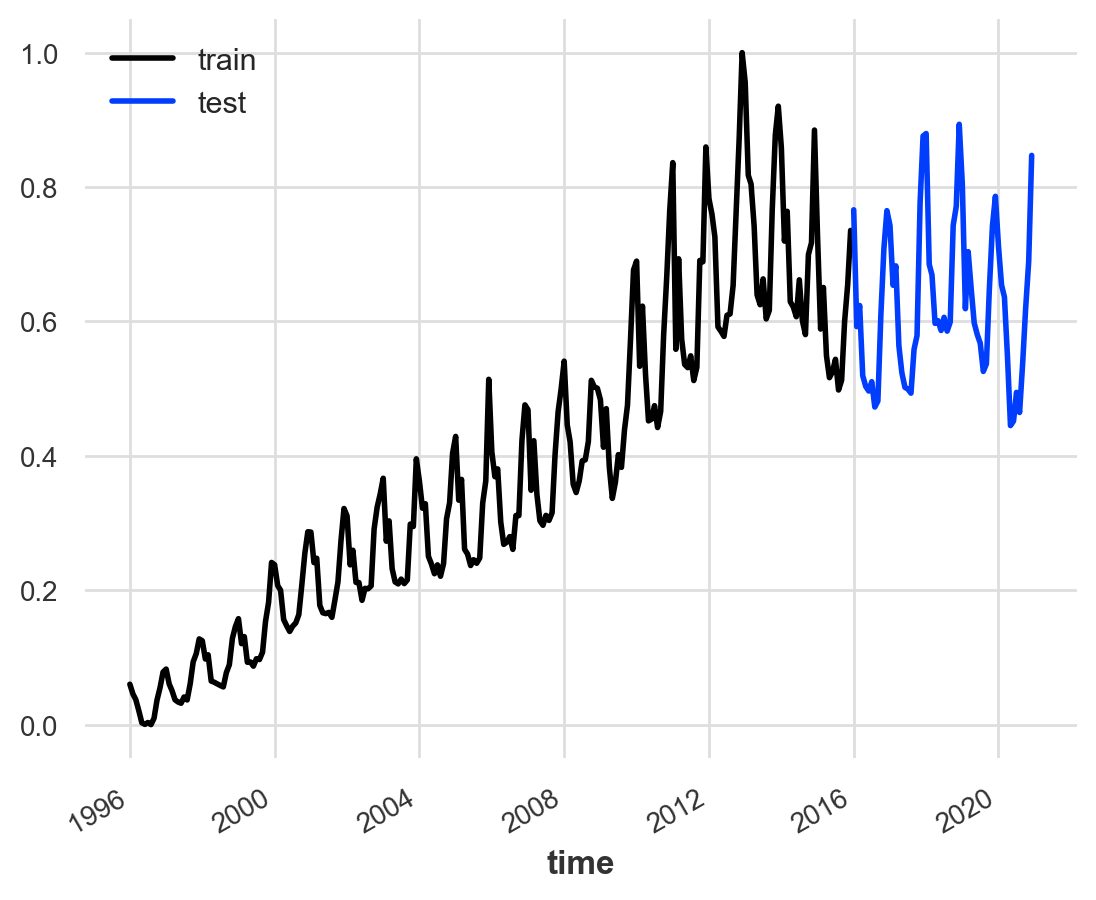

In [22]:
train, test = series_scaled.split_before(pd.Timestamp('20160101'))
train.plot(label='train')
test.plot(label='test')

In [27]:
# model = NBEATSModel(input_chunk_length=24 , output_chunk_length=12, n_epochs = 100 , random_state = 15)
model = RNNModel(
    input_chunk_length=12, model='LSTM', hidden_dim=300,
    n_rnn_layers=3, dropout=0.2, training_length=24,
    batch_size=10, n_epochs=300,
)

In [28]:
model.fit(train, verbose=True)

2022-11-18 01:40:42 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-11-18 01:40:42 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-18 01:40:42 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-18 01:40:42 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-18 01:40:42 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.8 M 
4 | V             | Linear           | 301   
---------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
14.470    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

2022-11-18 02:02:16 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


In [33]:
pred = model.predict(n=60, series=train)
# print("Mape = {:.2f}%".format(mape(series_scaled , pred)))

Predicting: 22it [00:00, ?it/s]

Mape = 9.74%


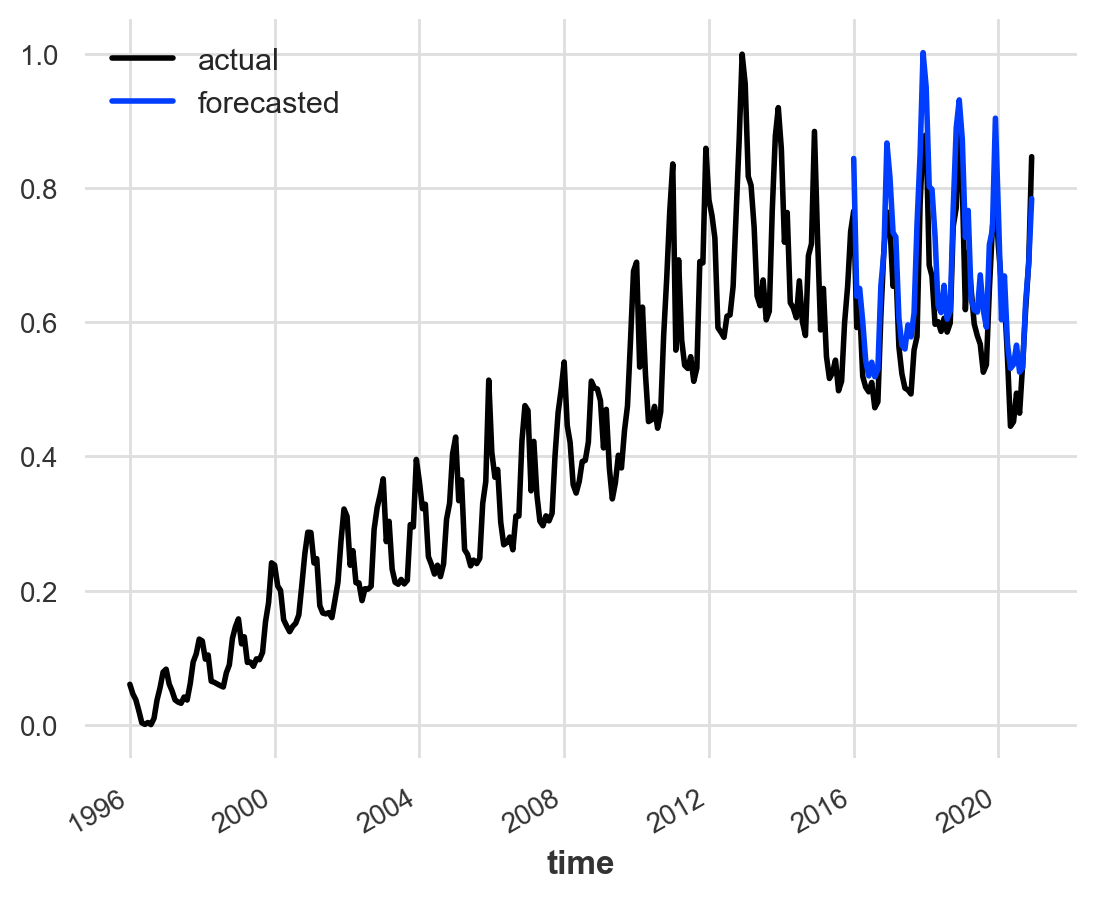

In [32]:
series_scaled.plot(label='actual')
pred.plot(label='forecasted')

Predicting: 22it [00:00, ?it/s]

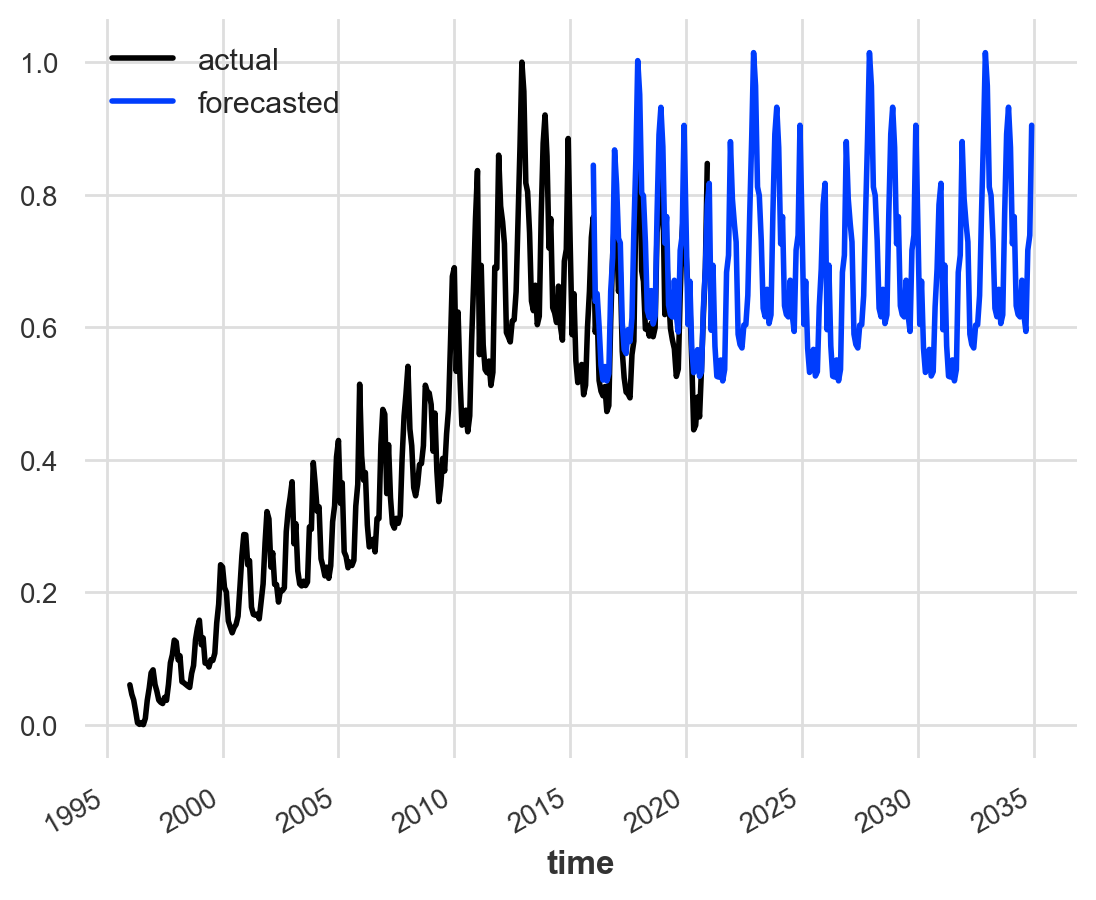

In [34]:
pred = model.predict(n=228, series=train)
series_scaled.plot(label='actual')
pred.plot(label='forecasted')

https://towardsdatascience.com/darts-swiss-knife-for-time-series-forecasting-in-python-f37bb74c126

In [38]:
model = NaiveSeasonal(K=12)
model.fit(train)
# prediction = model.predict(len(test))
prediction = model.predict(228)

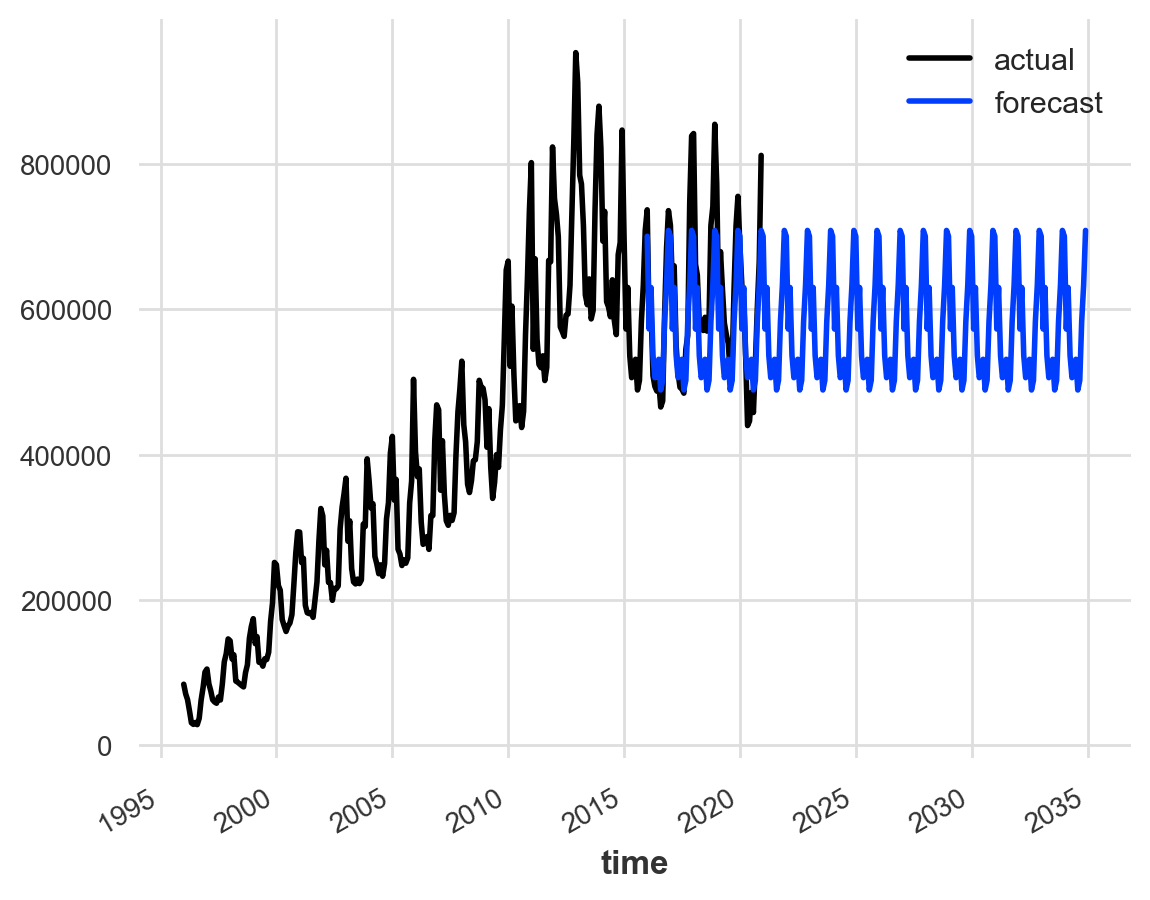

In [39]:
series.plot(label="actual")
prediction.plot(label='forecast')

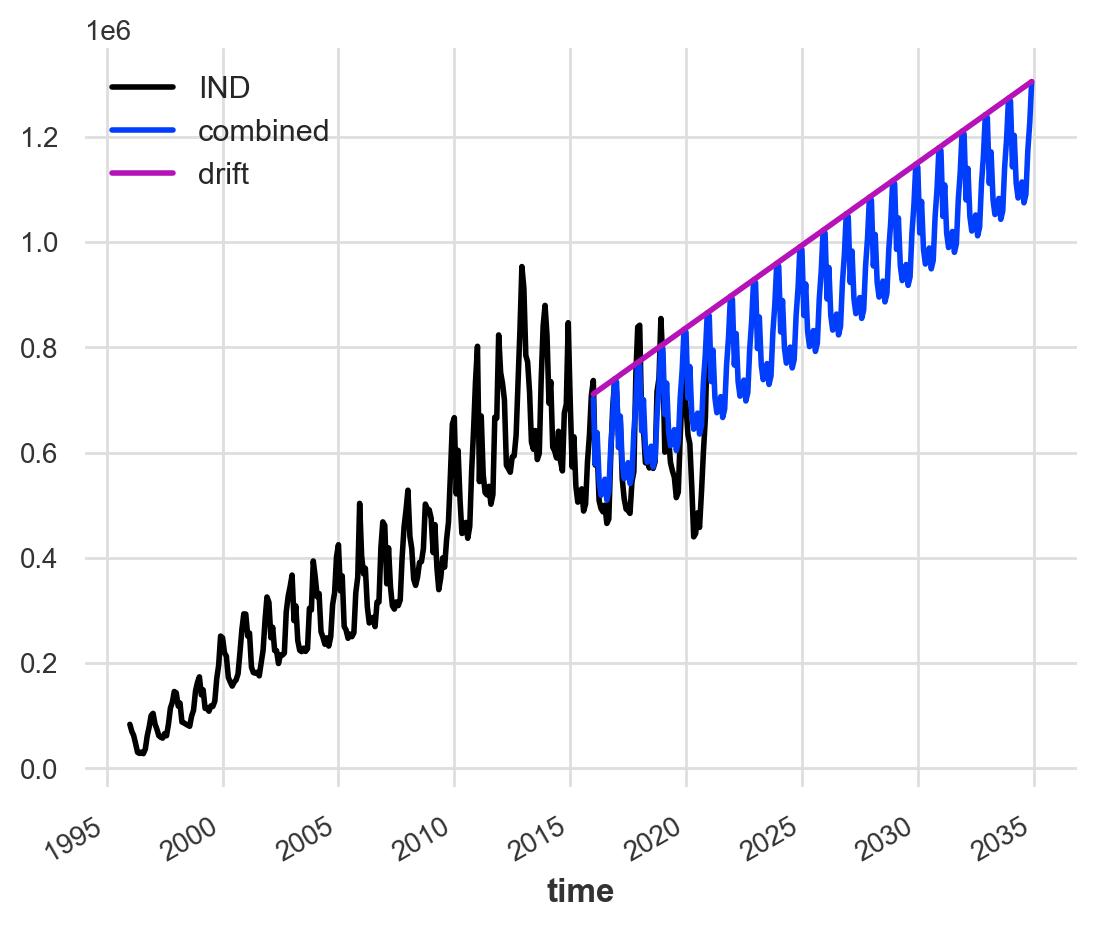

In [41]:
drift = NaiveDrift()
drift.fit(train)
drift_forecast = drift.predict(228)
combined_forecast = drift_forecast + prediction - train.last_value()
series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')